# TP2

Librerias.

In [5]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
# %matplotlib 

In [11]:
img = cv2.imread('fft_alfa_pred.png', cv2.IMREAD_GRAYSCALE)

In [12]:
h, w = img.shape

    # Implementacion de la función create_gauss_filter(h, w, k_size, sigma)

La función create_gauss_filter(h, w, k_size=5, sigma=5) crea un filtro Gaussiano de tamaño h x w en el dominio espacial y también calcula su Transformada de Fourier.

El filtro Gaussiano se crea calculando la distribución Gaussiana para cada píxel en el filtro, centrada en el píxel central del filtro. Después de calcular la distribución Gaussiana para cada píxel, el filtro se normaliza dividiéndolo por la suma de todos los valores en el filtro. Esto asegura que la suma de todos los valores en el filtro sea 1, lo cual es una propiedad de la distribución Gaussiana.

Finalmente, se calcula la Transformada de Fourier del filtro utilizando la función np.fft.fft2(filter). Esto convierte el filtro del dominio espacial al dominio de la frecuencia.

La función devuelve tanto el filtro Gaussiano en el dominio espacial como su Transformada de Fourier.

In [13]:
def create_gauss_filter(h, w, k_size=5, sigma=5):
    center_h = h // 2
    center_w = w // 2
    
    filter = np.zeros((h, w))
    
    for i in range(h):
        for j in range(w):
            filter[i, j] = np.exp(-((i - center_h) ** 2 + (j - center_w) ** 2) / (2 * sigma ** 2))
    
    filter /= np.sum(filter)
    filter_tf = np.fft.fft2(filter)
    
    return filter, filter_tf

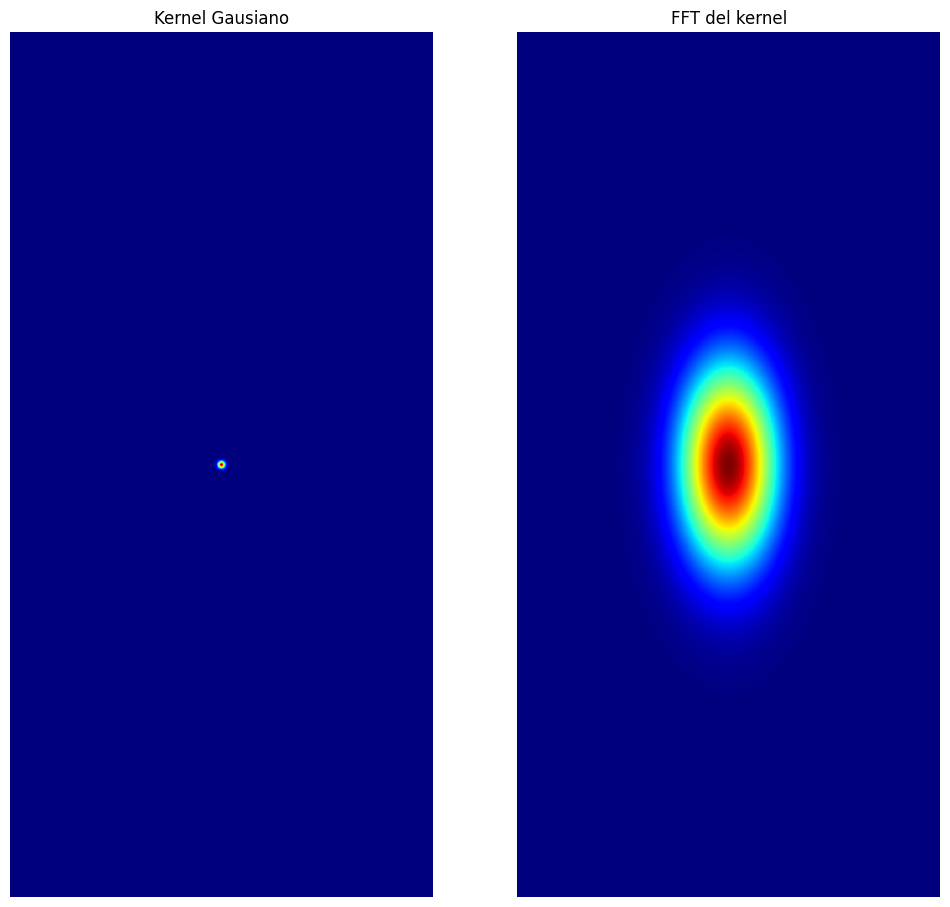

In [14]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=2)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

Text(0.5, 1.0, 'Desenfoque gausiano')

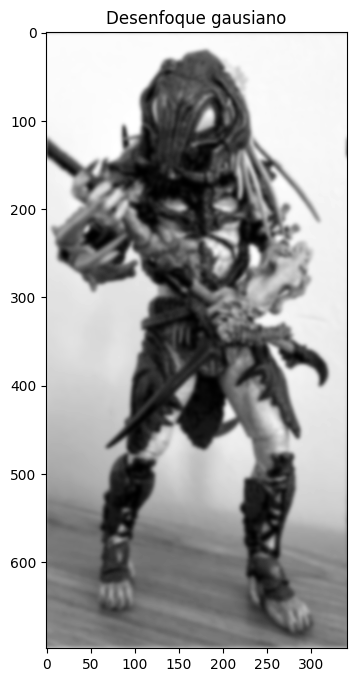

In [15]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

    # 1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una  imagen para validar el funcionamiento en el dominio espectral.

1. Definir los diferentes tamaños de kernel y valores de sigma que queremos probar.
2. Para cada combinación de tamaño de kernel y sigma:
    - Crear el filtro Gaussiano y su Transformada de Fourier utilizando la función create_gauss_filter().
    - Graficar el filtro Gaussiano y su Transformada de Fourier.
    - Aplicar el filtro Gaussiano a una imagen en el dominio espectral.
    - Graficar la imagen filtrada.

Defino un valor para el kernel y diferentes valores para sigma.

In [16]:
k_size = 5

In [17]:
sigma_values = [0.5, 1, 2, 3, 5]

Leo una imagen diferente.

In [18]:
img = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
assert img is not None, "Image could not be read. Check the path and try again."

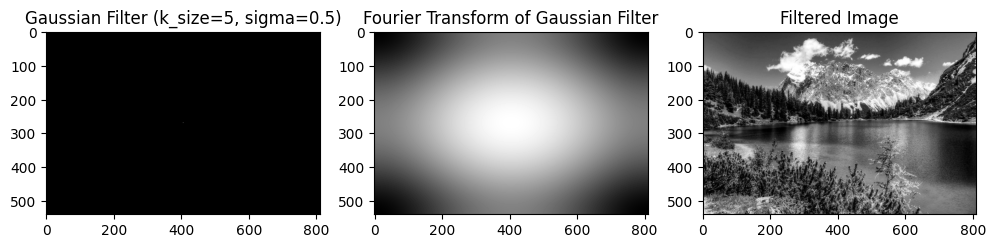

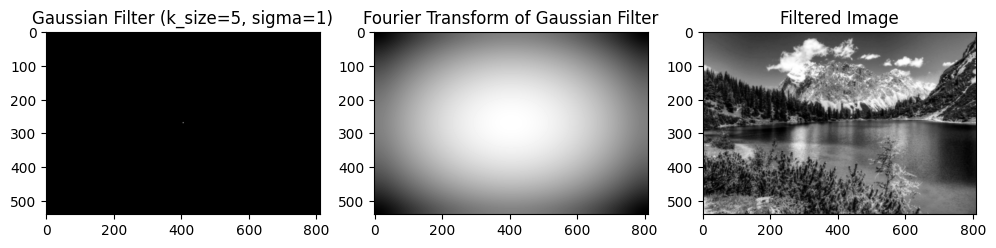

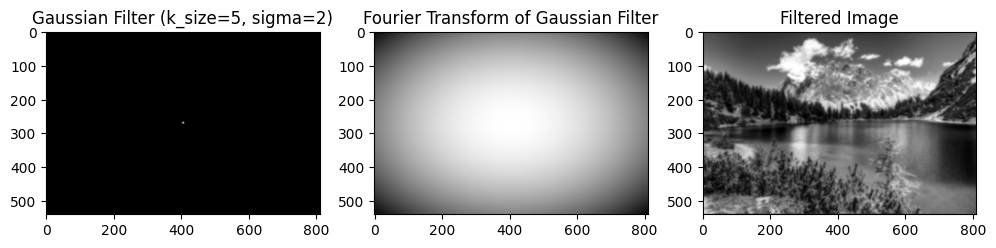

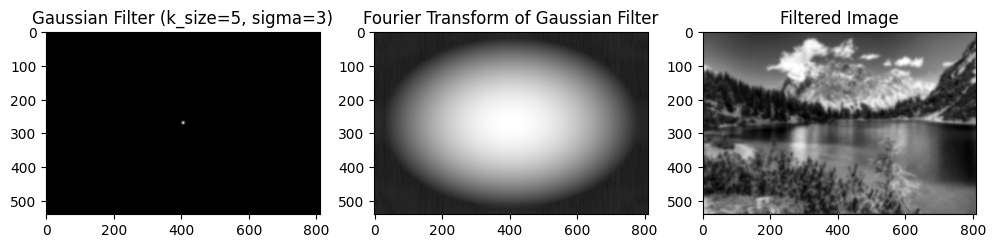

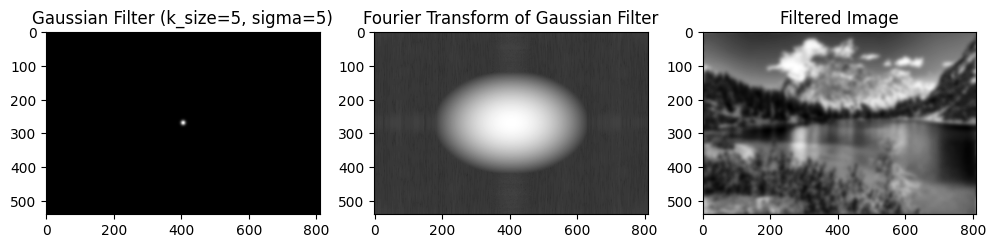

In [19]:
# Transformada de Fourier de la imagen
img_tf = np.fft.fft2(img)

for sigma in sigma_values:
    gauss_filter, gauss_filter_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size, sigma)
    
    img_tf_shifted = np.fft.fftshift(img_tf)
    gauss_filter_tf_shifted = np.fft.fftshift(gauss_filter_tf)
    
    # Aplico el filtro Gausiano a la imagen en el dominio espectral
    img_filtered_tf = img_tf_shifted * gauss_filter_tf_shifted
    
    # Aplico la transformada inversa de Fourier
    img_filtered = np.fft.ifft2(img_filtered_tf)
    
    img_filtered = np.fft.fftshift(img_filtered)  
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(gauss_filter, cmap='gray')
    plt.title(f'Gaussian Filter (k_size={k_size}, sigma={sigma})')
    plt.subplot(132)
    plt.imshow(np.log(np.abs(gauss_filter_tf_shifted)), cmap='gray')
    plt.title('Fourier Transform of Gaussian Filter')

    plt.subplot(133)
    plt.imshow(np.abs(img_filtered), cmap='gray')
    plt.title('Filtered Image')
    plt.show()  

    # 2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [20]:
# Filtro Gausiano con OpenCV
img_filtered_conv = cv2.GaussianBlur(img, (k_size, k_size), sigma)

In [21]:
# Aplico el filtro Gausiano usando filtrado espectral
gauss_filter, gauss_filter_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size, sigma)
img_tf_shifted = np.fft.fftshift(img_tf)
gauss_filter_tf_shifted = np.fft.fftshift(gauss_filter_tf)
img_filtered_tf = img_tf_shifted * gauss_filter_tf_shifted
img_filtered_spectral = np.fft.ifft2(img_filtered_tf)
img_filtered_spectral = np.fft.fftshift(img_filtered_spectral)

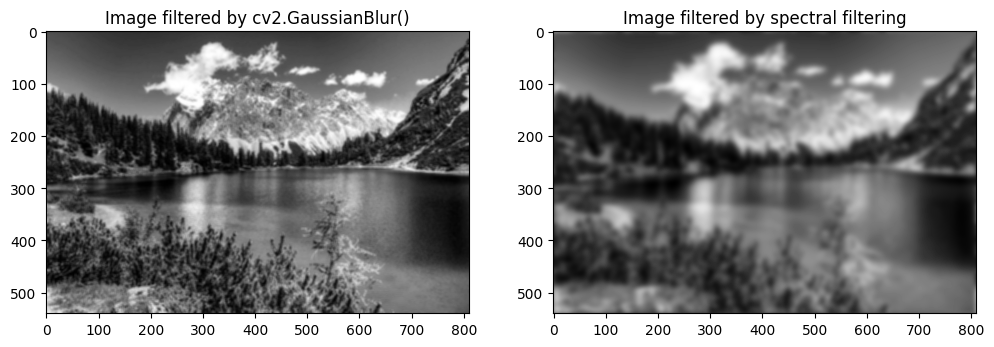

Mean squared error: 226.5596537809598


In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(img_filtered_conv, cmap='gray')
plt.title('Image filtered by cv2.GaussianBlur()')
plt.subplot(122)
plt.imshow(np.abs(img_filtered_spectral), cmap='gray')
plt.title('Image filtered by spectral filtering')
plt.show()

mse = np.mean((img_filtered_conv - np.abs(img_filtered_spectral)) ** 2)
print(f'Mean squared error: {mse}')

Implementacion de la métrica de calidad de imagen descrita en el documento «Image Sharpness Measure for Blurred Images in Frequency Domain»

In [25]:
def image_quality_measure(img):
    # Paso 1: Calcular F que es la representación de la Transformada de Fourier de la imagen I
    F = np.fft.fft2(img)
    
    # Paso 2: Encontrar Fc que se obtiene al desplazar el origen de F al centro.
    Fc = np.fft.fftshift(F)
    
    # Paso 3: Calcular AF = abs (Fc) donde AF es el valor absoluto de la transformada de Fourier centrada de la imagen I.
    AF = np.abs(Fc)
    
    # Paso 4: Calcular M = max (AF) donde M es el valor máximo del componente de frecuencia en F.
    M = np.max(AF)
    
    # Paso 5: Calcular TH = el número total de píxeles en F cuyo valor de píxel > thres, donde thres = M/1000.
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Calcular la medida de calidad de imagen (FM) a partir de la ecuación (1).
    # Medida de Calidad de Imagen (FM) = TH/M*N.
    FM = TH / (M * img.size)
    
    return FM

In [26]:
def apply_gaussian_filter_spectral(img, k_size, sigma):
    gauss_filter, gauss_filter_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size, sigma)
    img_tf_shifted = np.fft.fftshift(img_tf)
    gauss_filter_tf_shifted = np.fft.fftshift(gauss_filter_tf)
    img_filtered_tf = img_tf_shifted * gauss_filter_tf_shifted
    img_filtered = np.fft.ifft2(img_filtered_tf)
    img_filtered = np.fft.fftshift(img_filtered)
    return img_filtered

In [27]:
def calculate_image_quality(img_filtered_conv, img_filtered_spectral):
    conv_result = image_quality_measure(img_filtered_conv)
    spectral_result = image_quality_measure(np.abs(img_filtered_spectral))
    return conv_result, spectral_result

In [28]:
def plot_results(k_size, sigma_values, conv_results, spectral_results):
    plt.figure(figsize=(10, 6))
    plt.plot(sigma_values, conv_results, label='Convolution')
    plt.plot(sigma_values, spectral_results, label='Spectral filtering')
    for i, sigma in enumerate(sigma_values):
        plt.text(sigma, conv_results[i], f'{sigma}', ha='center')
        plt.text(sigma, spectral_results[i], f'{sigma}', ha='center')
    plt.xlabel('Sigma')
    plt.ylabel('Image Quality Measure')
    plt.title(f'Kernel Size = {k_size}')
    plt.legend()
    plt.show()

In [29]:
def process_images(img, k_size_values, sigma_values):
    for k_size in k_size_values:
        conv_results = []
        spectral_results = []
        for sigma in sigma_values:
            img_filtered_conv = cv2.GaussianBlur(img, (k_size, k_size), sigma)
            img_filtered_spectral = apply_gaussian_filter_spectral(img, k_size, sigma)
            conv_result, spectral_result = calculate_image_quality(img_filtered_conv, img_filtered_spectral)
            conv_results.append(conv_result)
            spectral_results.append(spectral_result)
        plot_results(k_size, sigma_values, conv_results, spectral_results)

Para esta comparativa, defino diferentes valores de kernel.

In [30]:
k_size_values = [3, 5, 7, 9, 11]

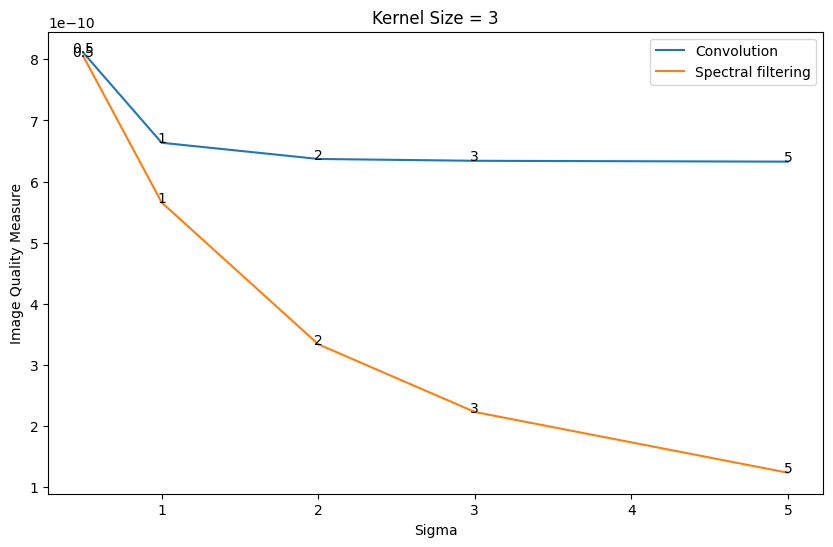

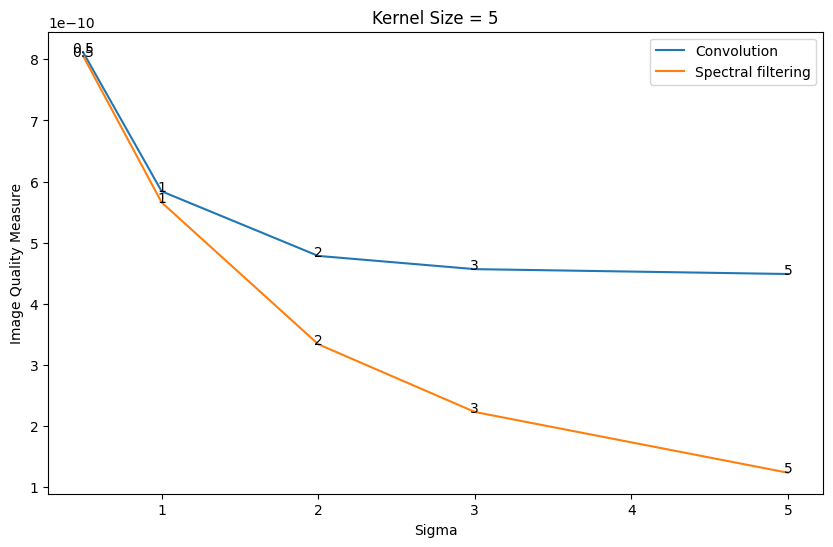

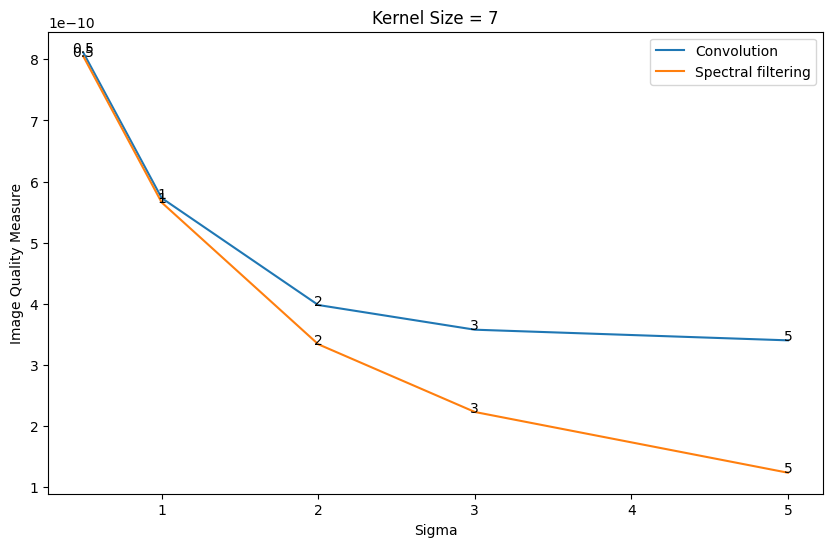

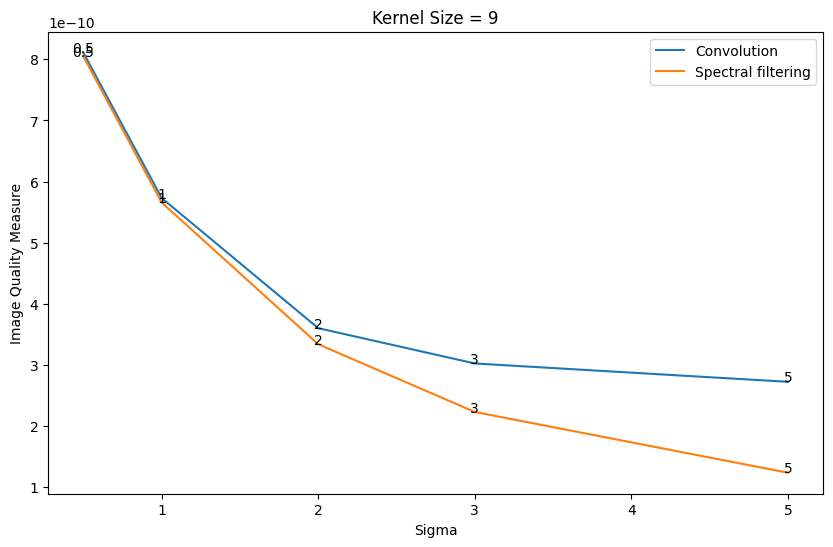

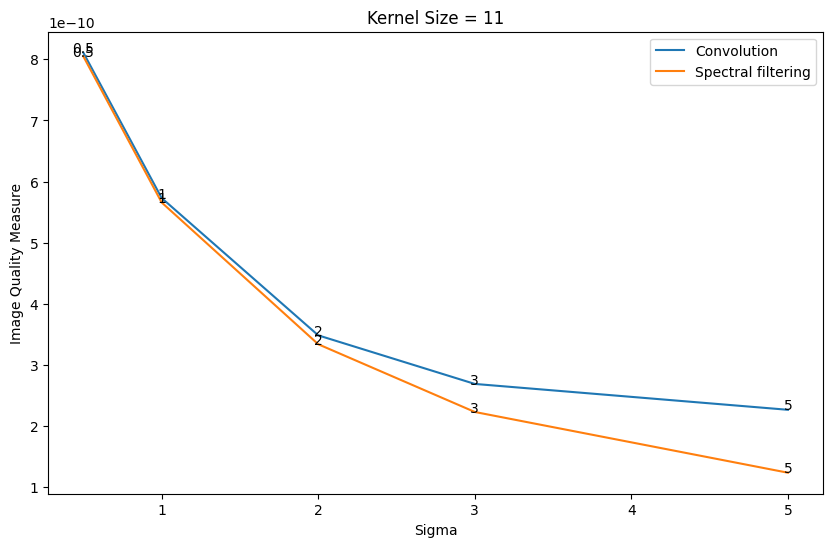

In [31]:
# Esta operacion podria tardar algunos segundos.
process_images(img, k_size_values, sigma_values)

    # 3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

Metodo elegido: La medida de enfoque de Brenner, que se basa en la segunda diferencia de los niveles de gris de una imagen. 

In [32]:
def brenner_focus_measure(img):
    # Calculo la segunda diferencia de los niveles de gris de la imagen
    img_shifted = np.roll(img, 2, axis=0)  
    second_diff = (img - img_shifted) ** 2  
    # Sumo la segunda diferencia al caudrado
    focus_measure = np.sum(second_diff)
    
    return focus_measure

In [33]:
def calculate_image_quality(img_filtered_conv, img_filtered_spectral):
    conv_result = brenner_focus_measure(img_filtered_conv)
    spectral_result = brenner_focus_measure(np.abs(img_filtered_spectral))
    return conv_result, spectral_result

Repito la comparacion usando mismos valores de tamano de kernel y sigma.

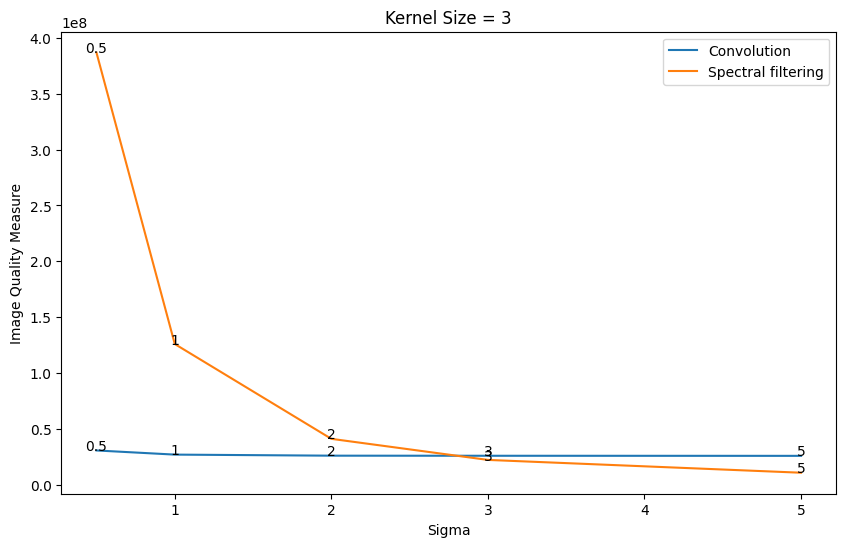

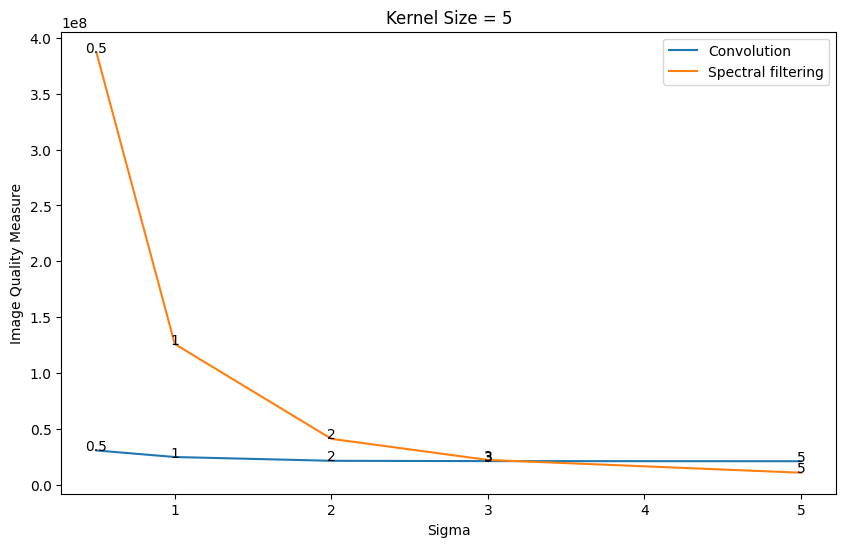

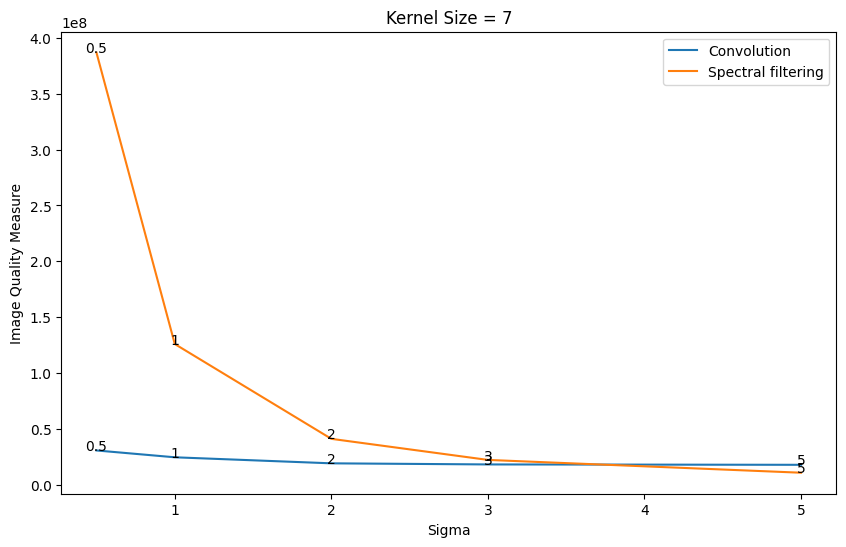

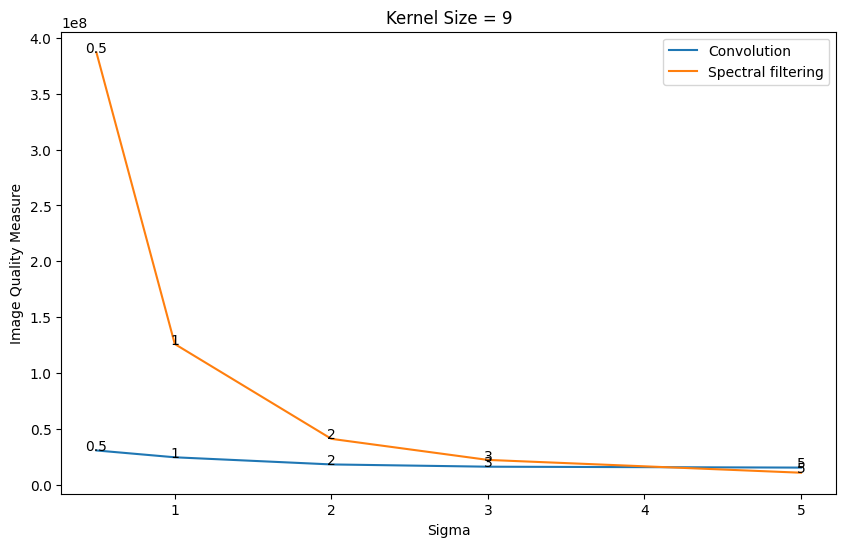

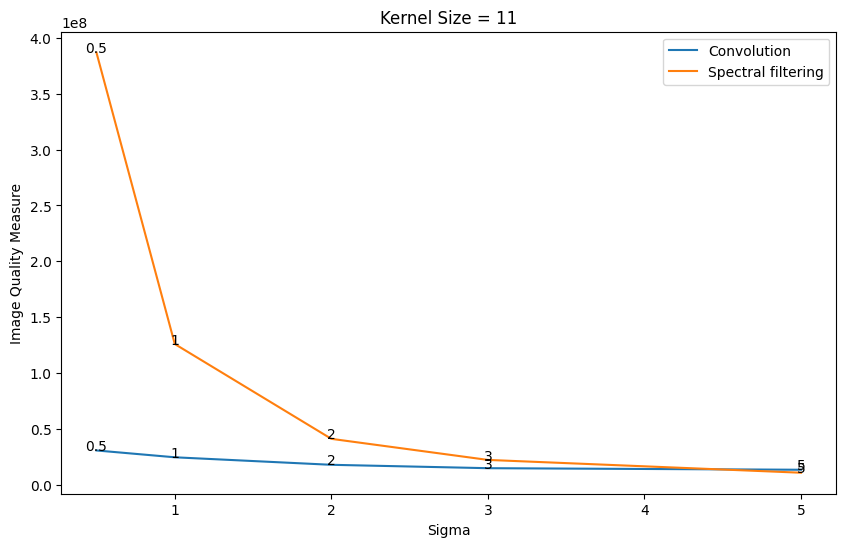

In [34]:
# Esta operacion podria tardar algunos segundos.
process_images(img, k_size_values, sigma_values)